In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [3]:
df = pd.read_csv("data/bank.csv")
df.shape

(11162, 17)

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [5]:
label_name = "deposit"

https://www.kaggle.com/medyasun/who-are-the-term-deposit-customers-85-accuracy

In [6]:
df.drop(labels = ['duration'], axis = 1, inplace = True)
df['deposit']=df['deposit'].map({'yes':1,'no':0})
df = pd.get_dummies(df, columns=['job','marital','education', 'month', 'default', 'housing',
 'loan', 'contact', 'poutcome'])
# , 'age_bin','balance_cat','pdays_bin','day_cat','day_bins','month_bins'])
cor_deposit=df.corr()
cor_deposit["deposit"].sort_values(ascending=False)

deposit                1.000000
poutcome_success       0.286642
contact_cellular       0.223252
housing_no             0.203888
pdays                  0.151593
previous               0.139867
month_mar              0.135438
month_oct              0.133783
month_sep              0.126901
loan_no                0.110580
job_retired            0.103827
job_student            0.099953
marital_single         0.094632
education_tertiary     0.094598
month_apr              0.090975
month_dec              0.086964
balance                0.081129
month_feb              0.051710
poutcome_other         0.044059
default_no             0.040680
job_management         0.036301
age                    0.034901
job_unemployed         0.033487
poutcome_failure       0.020714
contact_telephone      0.016420
education_unknown      0.014355
marital_divorced       0.005228
job_unknown            0.001889
job_admin.            -0.000610
job_self-employed     -0.004707
job_technician        -0.011557
month_au

In [7]:
df['deposit'].astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 11162, dtype: int64

In [8]:
label_name = 'deposit'
x_train = df.drop(labels=[label_name],axis=1)
y_train = df['deposit'].astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train,test_size=0.25, random_state=2)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8371, 50), (2791, 50), (8371,), (2791,))

In [9]:
kfold = StratifiedKFold(n_splits=10)

In [10]:
random_state = 42 
classifiers = [SVC(),
               DecisionTreeClassifier(),
               AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                  random_state=random_state,
                                  learning_rate=0.1),
               RandomForestClassifier(random_state=random_state),
               ExtraTreesClassifier(random_state=random_state),
               GradientBoostingClassifier(random_state=random_state),
               MLPClassifier(random_state=random_state),
               KNeighborsClassifier(),
               LogisticRegression(random_state = random_state),
               LinearDiscriminantAnalysis(),
               XGBClassifier(random_state = random_state),
               LGBMClassifier(random_state = random_state),
               CatBoostClassifier()
              ]

In [11]:
for c in classifiers:
    print(c.__class__.__name__)

SVC
DecisionTreeClassifier
AdaBoostClassifier
RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier
MLPClassifier
KNeighborsClassifier
LogisticRegression
LinearDiscriminantAnalysis
XGBClassifier
LGBMClassifier
CatBoostClassifier


In [12]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, 
                                      X_train, 
                                      y = Y_train, 
                                      scoring = "accuracy", 
                                      cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame(
    {"CrossValMeans":cv_means,"CrossValerrors": 
     cv_std,"Algorithm":[
         "SVC","DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
         "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors",
         "LogisticRegression","LinearDiscriminantAnalysis", 'XGBClassifier',
         'LGBMClassifier','CatBoostClassifier']})
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.574245,0.016874,SVC
1,0.636362,0.010094,DecisionTree
2,0.634572,0.012869,AdaBoost
3,0.723929,0.011323,RandomForest
4,0.695376,0.008636,ExtraTrees
5,0.736592,0.010326,GradientBoosting
6,0.642449,0.028934,MultipleLayerPerceptron
7,0.589896,0.013064,KNeighboors
8,0.670765,0.015684,LogisticRegression
9,0.698603,0.009740,LinearDiscriminantAnalysis


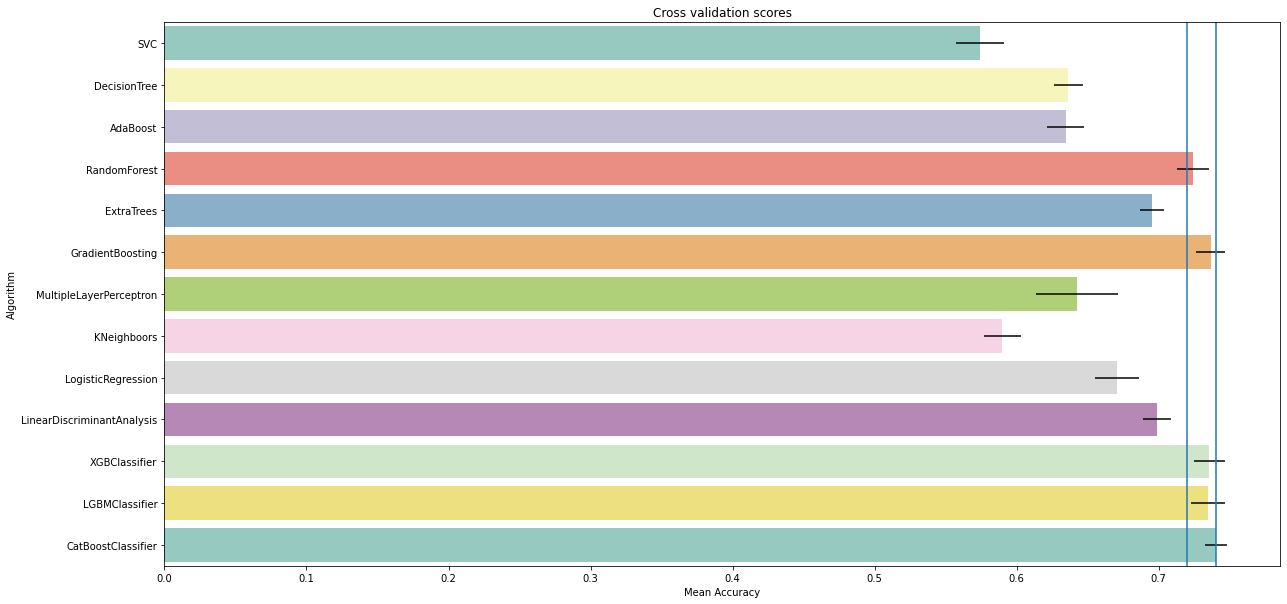

In [13]:
plt.figure(figsize=(20,10))
g = sns.barplot(data = cv_res, x="CrossValMeans", y="Algorithm", palette="Set3", orient = "h", **{'xerr':cv_std})
plt.axvline(0.74)
plt.axvline(0.72)
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")